In [47]:
import numpy as np


class Soccer:
    '''
    Actions [0 : Left, 1 : Up, 2 : Right, 3 : Down, 4 : Stand]
    '''
    def __init__(self, h=4, w=5, pA=[3, 2], pB=[1, 1], goalPositions=[1, 2], ballOwner=0, drawProbability=0):
        self.h = h
        self.w = w
        self.goalPositions = np.array(goalPositions)
        self.positions = np.array([pA, pB])
        self.initPositions = np.array([pA, pB])
        self.ballOwner = ballOwner
        self.drawProbability = drawProbability
        #self.reward = 0
        self.rewards = np.array([0, 0])

    def reset(self, pA=None, pB=None, ballOwner=None):
        if pA is not None:
            self.initPositions[0] = pA

        if pB is not None:
            self.initPositions[1] = pB

        if ballOwner is None:
            ballOwner = self.choosePlayer()

        self.positions = self.initPositions.copy()
        self.ballOwner = ballOwner
        return self.positions[0] / self.w, self.positions[1] / self.h, self.ballOwner

    
    def _move(self, actionA, actionB):
        reward = 0
        if np.random.rand() < self.drawProbability:
            return self.positions[0] / self.w, self.positions[1]/ self.h, self.ballOwner, reward, -reward, True
        first = self.choosePlayer()
        actions = [actionA, actionB]
        m1 = self.move(first, actions[first])
        # print(m1)
        if (m1[-1]):
            print(f'returning {m1}')
            return m1
        return self.move(1 - first, actions[1 - first])

    def move(self, player, action):
        opponent = 1 - player
        print(f'Move for player {player}')
       
        newPosition = self.positions[player] + self.actionToMove(action)

        reward = 0
        #self.rewards = np.array([0, 0])
        # If it's opponent position
        if (newPosition == self.positions[opponent]).all():
            self.ballOwner = opponent
        # If it's the goal
        elif self.ballOwner is player and self.isInGoal(*newPosition) >= 0:
            # reward = -2*( 1 - self.isInGoal(*newPosition)) + 1
            # self.rewards = np.array([reward, -reward ])
            reward = -2 * (1 - self.isInGoal(*newPosition)) + 1
            return self.positions[0] / self.w, self.positions[1] / self.h, self.ballOwner, reward, -reward, True
        # If it's in board
        elif self.isInBoard(*newPosition):
            self.positions[player] = newPosition
        return self.positions[0] / self.w, self.positions[1]/ self.h, self.ballOwner, reward, -reward, False

    def actionToMove(self, action):
        switcher = {
            0: [-1, 0],
            1: [0, 1],
            2: [1, 0],
            3: [0, -1],
            4: [0, 0],
        }
        return switcher.get(action)

    def isInGoal(self, x, y):
        g1, g2 = self.goalPositions
        if (g1 <= y <= g2):
            if x == -1:
                return 1
            elif x == self.w:
                return 0
        return -1

    def isInBoard(self, x, y):
        return (0 <= x < self.w and 0 <= y < self.h)

    def choosePlayer(self):
        return np.random.randint(0, 2)

    def draw(self, positions=None, ballOwner=None):
        positions = self.positions if positions is None else np.array(positions)
        ballOwner = self.ballOwner if ballOwner is None else ballOwner

        board = ''
        for y in range(self.h)[::-1]:
            for x in range(self.w):
                if ([x, y] == positions[0]).all():
                    board += 'A' if ballOwner == 0 else 'a'
                elif ([x, y] == positions[1]).all():
                    board += 'B' if ballOwner == 1 else 'b'
                else:
                    board += '-'
            board += '\n'

        print(board)



In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

class Net(nn.Module):
    def __init__(self,seed,input_dimension=6):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dimension, 10)  
        self.fc2 = nn.Linear(10, 5)  
        self.fc3 = nn.Linear(5, 1) 
        torch.manual_seed(seed)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self,input_ls,label_ls):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.01)
        for i in range(len(input_ls)):
            inputs = torch.tensor(input_ls[i],dtype=torch.float).unsqueeze(0)
            labels = torch.tensor(label_ls[i],dtype=torch.float).unsqueeze(0)
            optimizer.zero_grad()
            outputs = self.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
class Q_network:
    def __init__(self,max_cap=1000):
        seed = random.randint(0, 1000)
        self.target_network = self.build_model(seed)
        self.online_network = self.build_model(seed)
        self.replay_memory = deque()
    def build_model(self,seed):
        model = Net(seed=seed)
        return model
    

In [49]:
num_actions= 5

In [58]:
# from soccer import Soccer
# from neural_net import Q_network
import random
import numpy as np
import matplotlib.pyplot as plt
def epsilon_greedy(Q_network,state,epsilon):
    if random.random() < epsilon:
        return random.randint(0,num_actions-1)
    else:
        Q_values = []
        for i in range(num_actions):
            state_action = np.concatenate((state,np.array([i])),axis=0)
            Q_value = Q_network.online_network.forward(torch.Tensor(state_action))
            Q_values.append((Q_value,i))
        Q_values.sort(reverse=True)
        return Q_values[0][1]

def main():
    env = Soccer(drawProbability=0.01)
    player_A = Q_network()
    player_B = Q_network()
    num_episodes = 10
    epochs = 1000000
    frequency = 50
    epsilon=0.3
    stochastic_param=20
    gamma=0.9
    fill_memory = 100
    wins_A = []
    wins_B = []
    for episode in range(num_episodes):
        current_state_A,current_state_B,BallOwner = env.reset()
        for epoch in range(epochs):
            # for agent a
            action_A = epsilon_greedy(player_A,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),epsilon)
            action_B = epsilon_greedy(player_B,np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),epsilon)
            result = env._move(action_A,action_B)
            #print(result)
            next_state_A,next_state_B,next_BallOwner,reward_A,reward_B,done_env = result

            if epoch % 10 == 0:
                print(f'Ra = {reward_A}, Rb = {reward_B}')
        
            if(len(list(player_A.replay_memory))>1000):
                player_A.replay_memory.popleft()
            # player_A.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_A,reward_A,np.concatenate((next_state_A,next_state_B,np.array([next_BallOwner])),axis=0),done_env))
            if(len(list(player_B.replay_memory))>1000):
                player_B.replay_memory.popleft()
            player_B.replay_memory.append((np.concatenate((current_state_A,current_state_B,np.array([BallOwner])),axis=0),action_B,reward_B,np.concatenate((next_state_A, next_state_B,np.array([next_BallOwner])),axis=0),done_env))
            #print(f'Replay mem B[0] = {player_B.replay_memory[-1]} ')
            current_state_A = next_state_A
            current_state_B = next_state_B
            if (episode +1 )% 10 == 0 and episode > 0:
                print(f'-----------------Printing board at episode, epoch: {episode}, {epoch}----------------------------------')
                env.draw()
            if epoch < fill_memory and episode == 0:
                continue
            else:
                sample_for_A = random.sample(list(player_A.replay_memory), min(len(list(player_A.replay_memory)) ,(stochastic_param)))
                sample_for_B = random.sample(list(player_B.replay_memory), min(len(list(player_B.replay_memory)) ,(stochastic_param)))
                input_ls=[]
                label_ls=[]
                for sample in sample_for_A:
                    state,action,reward,next_state,done = sample
                    if done:
                        target = reward
                    else:
                        # print('printing concat:')
                        # print(f'next state = {next_state}')
                        # print(np.concatenate((next_state,[0]),axis=0).shape)
                        target = reward + gamma*max([player_A.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
                    input_ls.append(np.concatenate((state,[action]),axis=0))
                    label_ls.append(target)
                player_A.online_network.train(input_ls,label_ls)
                input_ls=[]
                label_ls=[]
                for sample in sample_for_B:
                    state,action,reward,next_state,done = sample
                    if done:
                        target = reward
                    else:
                        target = reward + gamma*max([player_B.target_network.forward(torch.Tensor(np.concatenate((next_state,[i]),axis=0))) for i in range(num_actions)])
                    input_ls.append(np.concatenate((state,[action]),axis=0))
                    label_ls.append(target)
                player_B.online_network.train(input_ls,label_ls)
            if epoch%frequency==0:
                player_A.target_network.load_state_dict(player_A.online_network.state_dict())
                player_B.target_network.load_state_dict(player_B.online_network.state_dict())
            if done_env:
                print("Episode number when done: ",episode)
                if reward_A == 1:
                    wins_A.append(reward_A)
                    wins_B.append(0)
                elif reward_B == 1:
                    wins_A.append(0)
                    wins_B.append(reward_B)
                else:
                    wins_A.append(0)
                    wins_B.append(0)
                break 
    plt.plot(np.cumsum(np.array(wins_A)),label='Player A')
    plt.plot(np.cumsum(np.array(wins_B)),label='Player B')
    plt.xlabel('Episodes')
    plt.ylabel('No of Wins')
    plt.legend()
    plt.show()


Move for player 1
Move for player 0
Ra = 0, Rb = 0
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Ra = 0, Rb = 0
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Ra = 0, Rb = 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 1
M

C:\Users\Gokul\AppData\Local\Temp\ipykernel_456\166582610.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label_ls[i],dtype=torch.float).unsqueeze(0)


Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Ra = 0, Rb = 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 0
returning (array([0. , 0.4]), array([0.  , 0.75]), 0, 1, -1, True)
Episode number when done:  0
Move for player 0
Move for player 1
Ra = 0, Rb = 0
Move for player 0
Move for player 1
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 1
Move for player 0
Move for player 0
returning (array([0. , 0.4]), array([0., 0.]), 0, 1, -1, True)
Episode number when

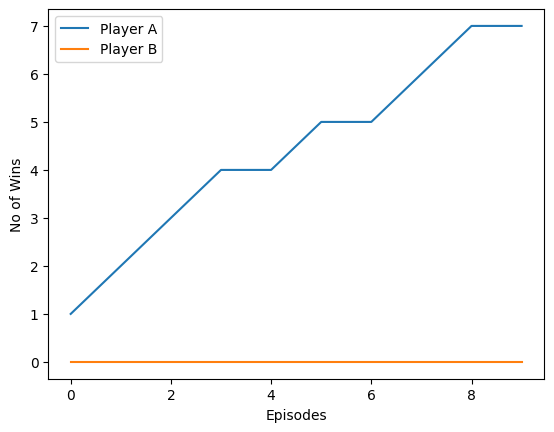

In [59]:
main()